In [14]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

Device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'Using device: {Device}')


Using device: cuda


# Dataset

In [15]:

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST normalization
])

# Download and load training data
train_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=True, 
    download=True, 
    transform=transform
)

# Download and load test data
test_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=False, 
    download=True, 
    transform=transform
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)




In [ ]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(8,8))
plt.imshow(train_dataset.data[0], cmap='gray')
plt.title(f'Label: {train_dataset.targets[0]}')
plt.axis('off')
plt.show()


In [17]:
def training_valitation_loop(model, train_loader, test_loader, epochs=1):
    losses = []
    model = model.to(Device)
    print(model)
    best_acc = 0.0
    best_model_wts = model.state_dict()
    # Define loss function and optimizer 

    # training loo
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss().to(Device)
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            # zero the parameter gradients
            optimizer.zero_grad()
            inputs, labels = inputs.to(Device), labels.to(Device)
            
            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            # print statistics
            running_loss += loss.item()
            if i % 100 == 99:    # print every 100 mini-batches
                #flush=True

                print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 100:.3f}')
                running_loss = 0.0


        correct = 0
        total = 0 
        for i, (inputs, labels) in enumerate(test_loader):
            inputs, labels = inputs.to(Device), labels.to(Device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item();
        if correct / total > best_acc:
            best_acc = correct / total
            best_model_wts = model.state_dict()
        print(f' epoch {epoch + 1}: accuracy {100 * correct / total} %')
    
    print('Finished Training')
    return losses,best_acc,best_model_wts 



# Models
---


## ViT

In [20]:
import torch
from torch import nn, einsum
import torch.nn.functional as F
from einops import rearrange, repeat

from einops.layers.torch import Rearrange


def pair(t):
    return t if isinstance(t, tuple) else (t, t)


class PatchEmbed(nn.Module):
  def __init__(self, img_size, patch_size, in_chans=3, embed_dim=768):
    super().__init__()
    self.img_size = pair(img_size)
    self.patch_height, self.patch_width = pair(patch_size)
    self.in_channels = in_chans
    self.embed_dim = embed_dim

    self.patch_dim = self.in_channels * self.patch_height * self.patch_width
    self.layernorm1 = nn.LayerNorm(self.patch_dim)
    self.linear = nn.Linear(self.patch_dim, self.embed_dim)
    self.layernorm2 = nn.LayerNorm(self.embed_dim)

  def forward(self, x):
    # c=3, h=16, w=16, p1=14, p2=14
    # print('before rearrange', x.shape)      # [1, 3, 224, 224]
    x = rearrange(x, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=self.patch_height, p2=self.patch_width)
    # print('after rearrange', x.shape)     # [1, 256, 588]
    x = self.layernorm1(x)                  # [1, 256, 588]
    x = self.linear(x)                      # [1, 256, 1024]
    x = self.layernorm2(x)                  # [1, 256, 1024]
    return x





class ViT(nn.Module):
    def __init__(self, config):
        super().__init__()
        img_size = config['img_size']
        n_classes = config['n_classes']
        dim = config['dim']
        depth = config['depth']
        heads = config['heads']
        mlp_dim = config['mlp_dim']
        pool = config.get('pool', 'cls')
        channels = config['channels']
        dim_head = config.get('dim_head', 64)
        dropout = config.get('dropout', 0.)
        emb_dropout = config.get('emb_dropout', 0.)
        patch_size = config.get('patch_size', -1)

        image_height, image_width = pair(img_size)    
    
        patch_height, patch_width = patch_size, patch_size
        num_patches = (image_height // patch_height) * (image_width // patch_width)

        num_input_to_transformer = num_patches if patch_size > 0 else image_height 

        #what if we just used rows?
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'
        if patch_size > 0: 
            self.to_patch_embedding = PatchEmbed(img_size=img_size, 
                                             patch_size=patch_size, 
                                             in_chans=channels, 
                                             embed_dim=dim)
            print(f'Using patch size of {patch_size}, resulting in {num_patches} patches') 
        else: 
            self.to_patch_embedding = nn.Sequential(
                Rearrange('b 1 w h -> b w h'),
                nn.LayerNorm(num_input_to_transformer ),
                nn.Linear(num_input_to_transformer, dim),
                nn.LayerNorm(dim)
            )
            print(f'Using rows as input, resulting in {num_input_to_transformer} patches')


        self.pos_embedding = nn.Parameter(torch.randn(1, num_input_to_transformer+1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = nn.TransformerEncoder(
           nn.TransformerEncoderLayer(
            d_model=dim, 
            nhead=heads,
            dim_feedforward=mlp_dim,
           dropout=dropout,
           batch_first=True,
           activation='gelu',
           ),
        num_layers=depth
        )

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Linear(dim, n_classes)

    def forward(self, img):
      
        #x = 
        x = self.to_patch_embedding(img)        # [1, 256, 1024]
        b, n, _ = x.shape

        # [1, 1, 1024]
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b=b)
        x = torch.cat((cls_tokens, x), dim=1)   # [1, 257, 1024], append one additional cls token
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)
        x = self.transformer(x)
        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)


## CNN

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, config):
        super().__init__()

        num_classes = config.get('n_classes',10)   #
        input_size = config.get('img_size',28)  #
        channels = config.get('channels',1)  #

        self.conv1 = nn.Conv2d(1,32,kernel_size=3)
        self.conv2 = nn.Conv2d(32,64,kernel_size=3)
        self.fc1 = nn.Linear(1600,128)
        self.fc2 = nn.Linear(128,num_classes)



    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2)
        x = F.gelu(self.conv2(x))
        x = F.max_pool2d(x,2)
        x = torch.flatten(x,1)
        x = F.gelu(self.fc1(x))
        x = self.fc2(x)
        return x

# Experiments

## Row-based ViT
---


In [ ]:
config = {
    "img_size": 28,
    "n_classes": 10,
    "dim": 64,
    "depth": 6,
    "heads": 8,
    "mlp_dim": 128,
    "channels": 1,
    "dropout": 0.1,
    "emb_dropout": 0.1,

}
model = ViT(config )
losses, best_acc, best_model_wts = training_valitation_loop(model, train_loader, test_loader)
print(f'Best accuracy: {100*best_acc} %')



Using rows as input, resulting in 28 patches
ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b 1 w h -> b w h')
    (1): LayerNorm((28,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=28, out_features=64, bias=True)
    (3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (

Text(0.5, 1.0, 'Training Loss Convergence')

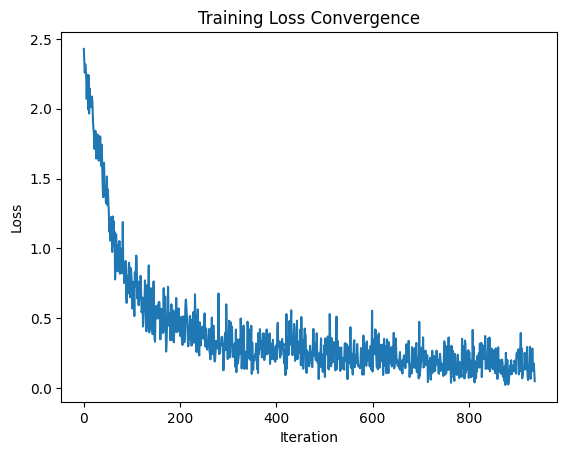

In [ ]:
# Convergence plot
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Convergence')

## Sample CNN
---

In [17]:
config = {
    "img_size": 28,
    "n_classes": 10,
    "channels": 64 }


cnn = SimpleCNN(config )
losses, best_acc, best_model_wts = training_valitation_loop(cnn, train_loader, test_loader)
print(f'Best accuracy: {100*best_acc} %')



SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
[Epoch 1, Batch 100] loss: 0.453
[Epoch 1, Batch 200] loss: 0.130
[Epoch 1, Batch 300] loss: 0.111
[Epoch 1, Batch 400] loss: 0.084
[Epoch 1, Batch 500] loss: 0.080
[Epoch 1, Batch 600] loss: 0.068
[Epoch 1, Batch 700] loss: 0.058
[Epoch 1, Batch 800] loss: 0.049
[Epoch 1, Batch 900] loss: 0.055
 epoch 1: accuracy 98.66 %
Finished Training
Best accuracy: 98.66 %


Text(0.5, 1.0, 'Training Loss Convergence')

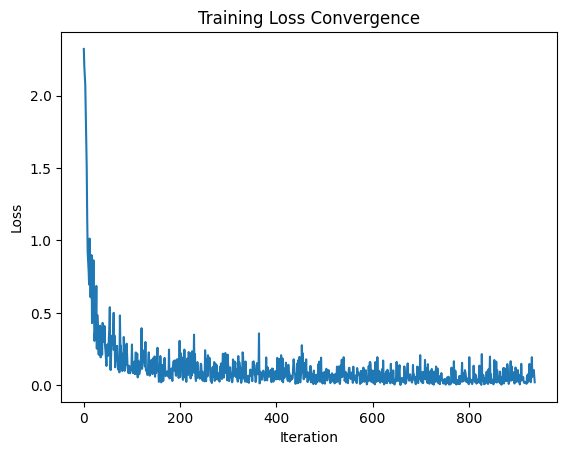

In [18]:
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Convergence')

In [23]:
print(f"Parameters: {sum(p.numel() for p in cnn.parameters()):,}")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")


Parameters: 225,034
Parameters: 205,442


## Analysis 

For my analysis, I set up two models. The first was a ViT that operates on a per row basis. Where as standard ViTs are trained on square patches on the input, I simply broke up the image into rows and used each row as an embedding.  

The second model I tested was a standard 2-layer CNN. This consists of 2 CNN layers, 2 max pooling operations, and 2 FCNs. For non-linearities, I used GeLUs. 

For training, I simply trained the model with a batch size of 64 since both seemed to converge pretty well this time. Evaluation was done on the test step.  

## Training time 

To get a clear comparison, I used the same hyperparameters for both model trainings. That is 1 epoch, Adam optimizer with an lr of 0.001.  

The CNN seemed to converge much faster -- by the first 100 samples, the loss had already dropped down to it's convergence loss. However, the ViT didn't settle down until around 500 samples or so. 

 

Additionally, execution time for 1 epoch was much faster for the CNN than the ViT. CNN finished one epoch of trained data in 16 seconds where as the ViT took 30 seconds. The CNN model has 220K parameters and the ViT has 205K parameters, so my assumption is that this has to do with the CNN filter's efficiency compared to the ViTs. 

## Performance 

The CNN performed better on the test dataset. The CNN received a 98% accuracy whereas the ViT received a 95%. This makes intuitive sense as ViT shine when we increase our dataset to colossal levels. At the size of our data set and the complexity, the CNN filters have enough capacity to extract optimal features. 

 

# Experiment: Tiny ViT 

My attempt and reducing the model size, code complexity and lines of code for the ViT model and maintaining good performance on validation set

In [54]:
import torch
from torch import nn, einsum
import torch.nn.functional as F
from einops import rearrange, repeat

from einops.layers.torch import Rearrange

class TinyViT(nn.Module):
    def __init__(self, config):
        super().__init__()
        img_size = config['img_size']
        n_classes = config['n_classes']
        dim = config['dim']
        depth = config['depth']
        heads = config['heads']
        mlp_dim = config['mlp_dim']
        pool = config.get('pool', 'cls')
        emb_dropout = config.get('emb_dropout', 0.)

        self.to_patch_embedding = nn.Sequential(
                Rearrange('b 1 w h -> b w h'),
                nn.Linear(img_size, dim, bias=False),
          )

        self.pos_embedding = nn.Parameter(torch.randn(1, img_size+1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))

        self.transformer = nn.TransformerEncoder(
           nn.TransformerEncoderLayer(
            d_model=dim, 
            nhead=heads,
            dim_feedforward=mlp_dim,
           batch_first=True,
           activation='gelu',
           ),
        num_layers=depth
        )
        self.mlp_head = nn.Linear(dim, n_classes)

    def forward(self, img):
      
        #x = 
        x = self.to_patch_embedding(img)        # [1, 256, 1024]
        b, n, _ = x.shape

        # [1, 1, 1024]
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b=b)
        x = torch.cat((cls_tokens, x), dim=1)   # [1, 257, 1024], append one additional cls token
        x += self.pos_embedding[:, :(n + 1)]
        return self.mlp_head(self.transformer(x).mean(dim = 1))


In [55]:
config = {
    "img_size": 28,
    "n_classes": 10,
    "dim": 64,
    "depth": 6,
    "heads": 1,
    "mlp_dim": 128,
    "channels": 1,
    "emb_dropout": 0.1,

}
model = TinyViT(config )
losses, best_acc, best_model_wts = training_valitation_loop(model, train_loader, test_loader)
print(f'Best accuracy: {100*best_acc} %')



/home/komelmerchant/.cache/pypoetry/virtualenvs/deeplearningwithtransformers-NqauVXp5-py3.10/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


TinyViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b 1 w h -> b w h')
    (1): Linear(in_features=28, out_features=64, bias=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (mlp_head): Linear(in_features=64, out_features=10, bias=True)
)
[Epoch 1, Batch 100] loss: 1.400
[Epoch 1, Batch 200] loss: 0.556
[Epoch 1, Batch

In [49]:
import onnx
from onnxruntime.quantization import quantize_dynamic, QuantType

# First export to ONNX
img, label = train_dataset[0]
img = img.unsqueeze(0)  # Add batch
img = img.to(Device)
torch.onnx.export(model, img, "model.onnx")

# Quantize ONNX model
quantize_dynamic("model.onnx", "model_quantized.onnx", 
                weight_type=QuantType.QUInt8)

/tmp/ipykernel_223471/3496278864.py:8: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(model, img, "model.onnx")


# Optimizations 
 
* Layer normalization actually wasn't necessary. In fact, I saw a 1% increase (95% -> 96%). 

* For the Transformer encoder, I am able to only use 1 Transformer encoder block and keep around the same accuracy (ie. depth = 1) and still keep 95% accuracy  

* Interestingly if I also made head = 1, I'd get a drop from 95% -> 91%. 

* If I changed the number of heads to 1, but increased depth to 6, performance shot back up to 95% 

* The nn.Identity() projection was unnecessary 